In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import yfinance as yf
import os
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()
from plotly.subplots import make_subplots
from os import listdir
from os.path import isfile, join
import warnings
warnings.simplefilter("ignore")
print('Current working directory: ', os.getcwd())

Current working directory:  /Users/saicharan/Desktop/gi/MPT


In [2]:
def get_column_from_csv(file, col_name):
    '''
    Takes the csv file which contains the tickers list and returns that into a program readable dataframe list
    file -> Path containing csv file that contains stocks list that yfinance has
    col_name -> Once the file is read as the dataframe, get column name that contains the tickers symbol
    '''
    try:
        print("Reading CSV")
        df = pd.read_csv(file)
    except FileExistsError:
        print("File Doesn't Exist")
    else:
        return df[col_name]

In [3]:
BASE_PATH = str(os.getcwd())
PATH = BASE_PATH + '/NSE/'
print(PATH)
S_DATE = '2017-02-01'
E_DATE = '2022-12-06'
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)
tickers = get_column_from_csv(BASE_PATH + '/nse.csv', 'Ticker')
print(tickers)

/Users/saicharan/Desktop/gi/MPT/NSE/
Reading CSV
0          BHARTIARTL.NS
1            ASHOKLEY.NS
2          AUROPHARMA.NS
3            SANWARIA.NS
4             ALMONDZ.NS
              ...       
2892      STCINDIA-EQ.NS
2893         INDOTECH.NS
2894      INDOTHAI-EQ.NS
2895    INDSWFTLTD-BE.NS
2896       INDSWFTLTD.NS
Name: Ticker, Length: 2897, dtype: object


In [4]:
def save_to_csv_from_yahoo(folder, ticker):
    '''
    Save the selected ticker to a folder specified in the argument. This is for 5 years data and for the daily data
    folder -> Path to save the files as a csv file.
    ticker -> Stock ticker to download.
    '''
    stock = yf.Ticker(ticker)
    try:
        print("Getting data for - ", ticker)
        df = stock.history(period="5y")
        time.sleep(2)
        the_file = folder + ticker.replace(".", "_") + '.csv'
        print(the_file, " Saved")
        df.to_csv(the_file)
    except Exception as ex:
        print("Couldn't get the data for : ", ticker)

In [5]:
## Change this to change number of securities
# number_of_securities = len(tickers)
# number_of_securities = 1595
number_of_securities = 1
for x in range(0, number_of_securities):
    save_to_csv_from_yahoo(PATH, tickers[x])
    print("Finished ", x)

Getting data for -  BHARTIARTL.NS
/Users/saicharan/Desktop/gi/MPT/NSE/BHARTIARTL_NS.csv  Saved
Finished  0


In [6]:
def get_stock_df_from_csv(ticker, PATH):
    '''
    Get the stock from the ticker that is an arg and the csv file path
    ticker -> stock symbol
    PATH -> csv file path for that ticker
    '''
    try:
        ticker = ticker.replace('.','_')
        df = pd.read_csv(PATH + ticker + '.csv', index_col=0)
    except Exception as e:
        print("File Doesn't Exist - ", e)
    else:
        return df

In [7]:
def add_daily_return_to_df(df):
    '''
    returns the dataframe with the daily return column appended
    df -> pass the dataframe which contains stock dataframe
    '''
    df['daily_return'] = (df['Close']/df['Close'].shift(1))-1
    return df

In [8]:
def add_cum_return_to_df(df):
    '''
    returns the dataframe with the cumulative return column appended
    df -> pass the dataframe which contains stock dataframe
    '''
    df['cum_return'] = (1+df['daily_return']).cumprod()
    return df

In [9]:
def add_bollinger_band(df):
    '''
    returns the dataframe with the middle band, upper band and lower band column appended
    df -> pass the dataframe which contains stock dataframe
    '''
    df['middle_band'] = df['Close'].rolling(window=20).mean()  
    df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
    df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()
    return df

In [10]:
def add_Ichimoku(df):
    # Conversion Line = (Highest Value in period + Lowest value in period)/2 (9 Sessions)
    high_val = df['High'].rolling(window=9).max()
    low_val = df['Low'].rolling(window=9).min()
    df['Conversion'] = (high_val + low_val)/2

    # Base Line = (Highest Value in period + Lowest value in period)/2 (26 Sessions)
    high_val2 = df['High'].rolling(window=26).max()
    low_val2 = df['Low'].rolling(window=26).min()
    df['Baseline'] = (high_val2 + low_val2)/2

    # Span A = (Conversion Value + Base Value)/2 (26 Sessions)
    df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2)
    # Span B = (Conversion Value + Base Value)/2 (52 Sessions)
    hi_val3 = df['High'].rolling(window=52).max()
    low_val3 = df['Low'].rolling(window=52).min()
    df['SpanB'] = ((hi_val3 + low_val3) / 2).shift(26)
    # Lagging Span = Price shifted back 26 periods
    df['Lagging'] = df['Close'].shift(-26)

    return df

In [11]:
tickers_without_dot = []
for x in tickers:
    tickers_without_dot.append(x.replace('.', '_'))
print(tickers_without_dot)
for x in range(0, len(tickers_without_dot)):
    try:
        print("Working on : ", tickers_without_dot[x])
        new_df = get_stock_df_from_csv(tickers_without_dot[x], PATH)
        # print(new_df)
        new_df = add_daily_return_to_df(new_df)
        new_df = add_cum_return_to_df(new_df)
        new_df = add_bollinger_band(new_df)
        new_df = add_Ichimoku(new_df)
        new_df.to_csv(PATH + tickers_without_dot[x] + '.csv')
        print('Finished on : ', tickers_without_dot[x], x)
    except Exception as ex:
        print(ex)

['BHARTIARTL_NS', 'ASHOKLEY_NS', 'AUROPHARMA_NS', 'SANWARIA_NS', 'ALMONDZ_NS', 'SBIN_NS', 'BPCL_NS', 'MBECL_NS', 'MAHABANK_NS', 'BOSCHLTD_NS', 'IDBI_NS', 'DABUR_NS', 'TCIDEVELOP_NS', 'DRREDDY_NS', 'DPSCLTD_NS', 'PRABHAT_NS', 'MAHLIFE_NS', 'LPDC_NS', 'KAUSHALYA_NS', 'IRB_NS', 'HDIL_NS', 'HDFC_NS', 'GOENKA_NS', 'ENERGYDEV_NS', 'SCHNEIDER_NS', 'TATAELXSI_NS', 'SWARAJENG_NS', 'RECLTD_NS', 'PEL_NS', 'EVERONN_NS', 'ESSELPACK_NS', 'ENTEGRA_NS', 'ADANIPORTS_NS', 'OFSS_NS', 'LICHSGFIN_NS', 'SITASHREE_NS', 'PFS_NS', 'PFC_NS', 'MUTHOOTFIN_NS', 'MAX_NS', 'MAGMA_NS', 'FACT_NS', 'WEIZFOREX_NS', 'GSPL_NS', 'GAIL_NS', 'POWERGRID_NS', 'VHL_NS', 'HINDUNILVR_NS', 'HINDPETRO_NS', 'HCC_NS', 'HIRECT_NS', 'SYNCOM_NS', 'ROHLTD_NS', 'JUBLINDS_NS', 'JISLJALEQS_NS', 'ZODJRDMKJ_NS', 'SBBJ_NS', 'PCJEWELLER-EQ_NS', 'JYOTHYLAB_NS', 'JUBLFOOD_NS', 'JUBILANT_NS', 'JSWSTEEL_NS', 'JPPOWER_NS', 'JPOLYINVST_NS', 'JKTYRE_NS', 'JKPAPER_NS', 'JISLDVREQS_NS', 'JINDCOT_NS', 'JINDALSAW_NS', 'JBFIND_NS', 'JAIHINDPRO_NS', 'JAGRAN

In [12]:
def add_fundamentals(df, ticker):
    """
    Adding the fundamental data to the dataframe
    df -> dataframe which contains stock data
    ticker -> ticker symbol for the same stock data
    """
    ticker = ticker.replace('_','.')
    tk = yf.Ticker(ticker).info
    df['sector'] = tk['sector']
    df['market_cap'] = tk['marketCap']
    return df

In [13]:
def add_sectors(file, path):
    df = pd.read_csv(file)
    for index, row in df.iterrows():
        if str(row.Sector) == 'nan':
            x = row.Ticker
            tk = yf.Ticker(x).info
            try:
                df.loc[df.Ticker == x,'Sector'] = tk['sector']
                df.to_csv(path)
            except Exception as e:
                df.loc[df.Ticker == x,'Sector'] = "NO"
                df.to_csv(path)
                print(e)
            print(x)
        else:
            pass
    return df

In [14]:
def plot_with_boll_bands(df, ticker):
    
    fig = go.Figure()

    candle = go.Candlestick(x=df.index, open=df['Open'],
    high=df['High'], low=df['Low'],
    close=df['Close'], name="Candlestick")

    upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
    line=dict(color='rgba(250, 0, 0, 0.75)', 
    width=1), name="Upper Band")

    mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
    line=dict(color='rgba(0, 0, 250, 0.75)', 
    width=0.7), name="Middle Band")

    lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
    line=dict(color='rgba(0, 250, 0, 0.75)', 
    width=1), name="Lower Band")

    fig.add_trace(candle)
    fig.add_trace(upper_line)
    fig.add_trace(mid_line)
    fig.add_trace(lower_line)

    fig.update_xaxes(title="Date", rangeslider_visible=True)
    fig.update_yaxes(title="Price")

    # USED FOR NON-DAILY DATA : Get rid of empty dates and market closed
    # fig.update_layout(title=ticker + " Bollinger Bands",
    # height=1200, width=1800, 
    #               showlegend=True, 
    #               xaxis_rangebreaks=[
    #         dict(bounds=["sat", "mon"]),
    #         dict(bounds=[16, 9.5], pattern="hour"), 
    #         dict(values=["2021-12-25", "2022-01-01"])
    #     ])
        
    fig.update_layout(title=ticker + " Bollinger Bands",
    height=700, width=1000, showlegend=True)
    fig.show()

In [15]:
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.4)'
    else:
        return 'rgba(250,0,0,0.4)'

def get_Ichimoku(df):

    candle = go.Candlestick(x=df.index, open=df['Open'],
    high=df['High'], low=df["Low"], close=df['Close'], name="Candlestick")

    df1 = df.copy()
    fig = go.Figure()
    df['label'] = np.where(df['SpanA'] > df['SpanB'], 1, 0)
    df['group'] = df['label'].ne(df['label'].shift()).cumsum()

    df = df.groupby('group')

    dfs = []
    for name, data in df:
        dfs.append(data)

    for df in dfs:
        fig.add_traces(go.Scatter(x=df.index, y=df.SpanA,
        line=dict(color='rgba(0,0,0,0)')))

        fig.add_traces(go.Scatter(x=df.index, y=df.SpanB,
        line=dict(color='rgba(0,0,0,0)'),
        fill='tonexty',
        fillcolor=get_fill_color(df['label'].iloc[0])))

    baseline = go.Scatter(x=df1.index, y=df1['Baseline'], 
    line=dict(color='pink', width=2), name="Baseline")

    conversion = go.Scatter(x=df1.index, y=df1['Conversion'], 
    line=dict(color='black', width=1), name="Conversion")

    lagging = go.Scatter(x=df1.index, y=df1['Lagging'], 
    line=dict(color='purple', width=2), name="Lagging")

    span_a = go.Scatter(x=df1.index, y=df1['SpanA'], 
    line=dict(color='green', width=2, dash='dot'), name="Span A")

    span_b = go.Scatter(x=df1.index, y=df1['SpanB'], 
    line=dict(color='red', width=1, dash='dot'), name="Span B")

    fig.add_trace(candle)
    fig.add_trace(baseline)
    fig.add_trace(conversion)
    fig.add_trace(lagging)
    fig.add_trace(span_a)
    fig.add_trace(span_b)
    
    fig.update_layout(height=700, width=1000, showlegend=True)

    fig.show()

In [16]:
def get_cum_ret_for_stocks(stock_df):
    # print(stock_df)
    tickers = []
    cum_rets = []
    for index, row in stock_df.iterrows():
        # print(index)
        df = get_stock_df_from_csv(row['Ticker'].replace('.','_'), PATH)
        # print(df)
        if df is None or len(df)==0:
            pass
        else:
            tickers.append(row['Ticker'])
            # print(row['Ticker'])
            # print(df['cum_return'])
            cum = df['cum_return'].iloc[-1]
            cum_rets.append(cum)
    return pd.DataFrame({'Ticker':tickers, 'CUM_RET':cum_rets})

In [17]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        # print(x)
        df = get_stock_df_from_csv(x, PATH)
        
        # NEW Check if your dataframe has duplicate indexes
        # if not df.index.is_unique:
        #     # Delete duplicates 
        #     df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

In [18]:
sec_df = pd.read_csv(BASE_PATH + '/nse-sectors.csv')
print(sec_df.Sector.unique())

['Communication Services' 'Industrials' 'Healthcare' 'Consumer Defensive'
 'Financial Services' 'Energy' 'Consumer Cyclical' 'Real Estate'
 'Utilities' 'NO' 'Technology' 'Basic Materials' 'Services'
 'Consumer Goods' 'Financial' 'Industrial Goods']


In [19]:
indus_df = sec_df.loc[sec_df['Sector'] == "Industrials"]
health_df = sec_df.loc[sec_df['Sector'] == "Healthcare"]
it_df = sec_df.loc[sec_df['Sector'] == "Technology"]
comm_df = sec_df.loc[sec_df['Sector'] == "Communication Services"]
staple_df = sec_df.loc[sec_df['Sector'] == "Consumer Goods"]
discretion_df = sec_df.loc[sec_df['Sector'] == "Consumer Cyclical"]
utility_df = sec_df.loc[sec_df['Sector'] == "Utilities"]
financial_df = sec_df.loc[sec_df['Sector'] == "Financial"]
material_df = sec_df.loc[sec_df['Sector'] == "Basic Materials"]
restate_df = sec_df.loc[sec_df['Sector'] == "Real Estate"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]

In [20]:
indus_df

,Ticker,Sector
1,ASHOKLEY.NS,Industrials
7,MBECL.NS,Industrials
18,KAUSHALYA.NS,Industrials
19,IRB.NS,Industrials
24,SCHNEIDER.NS,Industrials
...,...,...
2865,MANAKSIA.NS,Industrials
2870,MANUGRAPH.NS,Industrials
2887,REPRO.NS,Industrials
2890,SEAMECLTD.NS,Industrials


In [21]:
industrial = get_cum_ret_for_stocks(indus_df)
health_care = get_cum_ret_for_stocks(health_df)
it = get_cum_ret_for_stocks(it_df)
# commun = get_cum_ret_for_stocks(comm_df)
staple = get_cum_ret_for_stocks(staple_df)
discretion = get_cum_ret_for_stocks(discretion_df)
utility = get_cum_ret_for_stocks(utility_df)
finance = get_cum_ret_for_stocks(financial_df)
material = get_cum_ret_for_stocks(material_df)
restate = get_cum_ret_for_stocks(restate_df)
energy = get_cum_ret_for_stocks(energy_df)

In [22]:
print(len(industrial), len(health_care), len(it), len(staple), len(discretion), len(utility), len(finance), len(material), len(restate), len(energy))

244 77 77 0 246 28 2 214 38 25


In [23]:
industrial.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
107,ESABINDIA.NS,6.234791
192,INGERRAND.NS,5.027875
98,ELECON.NS,4.943334
111,KABRAEXTRU.NS,4.917255
146,KEI.NS,4.869490
17,PRAJIND.NS,4.853621
211,TIMKEN.NS,3.954445
116,HILTON.NS,3.886986
58,ASTRAL.NS,3.837364
175,GRINDWELL.NS,3.803771


In [24]:
df_esab = get_stock_df_from_csv('ESABINDIA.NS', PATH)
get_Ichimoku(df_esab)

In [25]:
health_care.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
48,JAGSNPHARM.NS,11.817300
49,JBCHEPHARM.NS,6.816240
20,IOLCP.NS,4.469784
62,POLYMED.NS,4.012893
11,ABBOTINDIA.NS,3.831001
21,APOLLOHOSP.NS,3.826957
22,ASTRAZEN.NS,3.442319
31,KOVAI.NS,3.067462
34,DIVISLAB.NS,2.934650
43,GRANULES.NS,2.758245


In [26]:
it.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
70,TANLA.NS,19.637162
30,DSSL.NS,9.323230
65,SAKSOFT.NS,7.926670
49,KERNEX.NS,7.566186
63,RSYSTEMS.NS,7.479994
0,TATAELXSI.NS,6.775008
59,PERSISTENT.NS,6.251427
33,PGEL.NS,5.377998
36,FCSSOFT.NS,5.222222
16,ADSL.NS,4.601358


In [27]:
staple.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET


In [28]:
discretion.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
138,GOLDIAM.NS,12.872550
129,GANGOTRI.NS,7.666666
236,CANTABIL.NS,7.490586
244,TRIDENT.NS,5.467376
115,GOKEX.NS,4.569507
12,KPRMILL.NS,4.384162
137,PGIL.NS,4.151568
230,WEIZMANIND.NS,4.119220
18,TRENT.NS,4.085876
58,ASAL.NS,4.029054


In [29]:
utility.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
12,ADANIPOWER.NS,7.149425
11,ADANITRANS.NS,4.621972
6,JSWENERGY.NS,3.825654
24,TATAPOWER.NS,3.061730
18,GUJGASLTD.NS,2.972421
22,TORNTPOWER.NS,2.412566
10,NHPC.NS,2.097014
4,POWERGRID.NS,2.050554
13,SURANAT&P.NS,2.010101
9,NTPC.NS,1.725716


In [30]:
finance.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
0,ARIHANT.NS,0.995419
1,BSELINFRA.NS,0.333333


In [31]:
material.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
188,PRAKASHSTL.NS,21.250000
13,XPROINDIA.NS,16.206340
49,ALKYLAMINE.NS,10.771438
20,USHAMART.NS,9.461976
113,FCL.NS,8.554024
211,LINDEINDIA.NS,8.253417
166,DEEPAKNTR.NS,7.936518
137,ISMTLTD.NS,7.045834
202,SRF.NS,6.372701
60,APLAPOLLO.NS,6.311810


In [32]:
restate.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
35,BRIGADE.NS,2.694863
0,MAHLIFE.NS,2.512444
13,GANESHHOUC.NS,2.441934
9,ANANTRAJ.NS,2.305241
31,PTL.NS,2.183577
25,PHOENIXLTD.NS,1.910266
4,OBEROIRLTY.NS,1.838628
15,DLF.NS,1.739828
20,GODREJPROP.NS,1.573044
19,MOTOGENFIN.NS,1.535433


In [33]:
energy.sort_values(by=['CUM_RET'], ascending=False).head(10)

,Ticker,CUM_RET
5,ADANIENT.NS,22.480640
24,REFEX.NS,16.751775
10,DOLPHINOFF.NS,3.915003
2,RELIANCE.NS,2.735901
11,JINDRILL.NS,1.962010
20,PANAMAPET.NS,1.920547
13,SELAN.NS,1.698271
6,AEGISCHEM.NS,1.693035
3,OIL.NS,1.682608
12,HINDOILEXP.NS,1.325875


In [34]:
risk_free_rate = 0.0125

In [35]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers.sort()
len(tickers)

2897

In [36]:
stocks = ['ESABINDIA.NS', 'EKC.NS', 'HGS.NS','POLYMED.NS','DIVISLAB.NS',
 'TATAELXSI.NS','ADANITRANS.NS',
 'TATAPOWER.NS','POWERGRID.NS','RELIANCE.NS','ADANIENT.NS']
num_stocks = len(stocks)
num_stocks

11

In [37]:
mult_df = merge_df_by_column_name('Close',  S_DATE, 
                                  E_DATE, *stocks)
mult_df.head()

,ESABINDIA.NS,EKC.NS,HGS.NS,POLYMED.NS,DIVISLAB.NS,TATAELXSI.NS,ADANITRANS.NS,TATAPOWER.NS,POWERGRID.NS,RELIANCE.NS,ADANIENT.NS
Date,,,,,,,,,,,
2018-03-08 00:00:00+05:30,609.394897,48.114998,339.804871,243.079025,965.873352,935.821777,177.500000,68.996933,111.213837,883.566223,90.729179
2018-03-09 00:00:00+05:30,602.679199,47.718174,330.965027,242.933472,962.020203,936.195435,182.750000,69.083282,109.790970,885.165710,83.828491
2018-03-12 00:00:00+05:30,607.142883,44.890800,337.975250,242.690887,976.565613,946.656250,185.300003,69.817299,110.986176,901.839539,87.131157
2018-03-13 00:00:00+05:30,609.475220,46.974129,342.806366,243.661255,997.420349,943.994324,184.399994,70.249062,111.014641,903.342041,85.788612
2018-03-14 00:00:00+05:30,606.781006,46.775715,340.545044,243.612732,1016.108032,943.620667,184.050003,69.428703,110.616241,900.627808,87.936684


In [38]:
# fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
# fig.update_xaxes(title="Date", rangeslider_visible=True)
# fig.update_yaxes(title="Price")
# fig.update_layout(height=700, width=1000, 
#                   showlegend=True)
# fig.show()

In [39]:
mult_cum_df = merge_df_by_column_name('cum_return',  S_DATE, 
                                  E_DATE, *stocks)
mult_cum_df.head()

,ESABINDIA.NS,EKC.NS,HGS.NS,POLYMED.NS,DIVISLAB.NS,TATAELXSI.NS,ADANITRANS.NS,TATAPOWER.NS,POWERGRID.NS,RELIANCE.NS,ADANIENT.NS
Date,,,,,,,,,,,
2018-03-08 00:00:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-09 00:00:00+05:30,0.988980,0.991753,0.973986,0.999401,0.996011,1.000399,1.029577,1.001251,0.987206,1.001810,0.923942
2018-03-12 00:00:00+05:30,0.996305,0.932990,0.994616,0.998403,1.011070,1.011577,1.043944,1.011890,0.997953,1.020681,0.960343
2018-03-13 00:00:00+05:30,1.000132,0.976289,1.008833,1.002395,1.032662,1.008733,1.038873,1.018148,0.998209,1.022382,0.945546
2018-03-14 00:00:00+05:30,0.995711,0.972165,1.002178,1.002196,1.052010,1.008334,1.036901,1.006258,0.994627,1.019310,0.969222


In [40]:
# fig = px.line(mult_cum_df, x=mult_cum_df.index, y=mult_cum_df.columns)
# fig.update_xaxes(title="Date", rangeslider_visible=True)
# fig.update_yaxes(title="Price")
# fig.update_layout(height=700, width=1000, 
#                   showlegend=True)
# fig.show()

In [41]:
mult_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 2018-03-08 00:00:00+05:30 to 2022-12-05 00:00:00+05:30
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ESABINDIA.NS   1172 non-null   float64
 1   EKC.NS         1172 non-null   float64
 2   HGS.NS         1172 non-null   float64
 3   POLYMED.NS     1172 non-null   float64
 4   DIVISLAB.NS    1172 non-null   float64
 5   TATAELXSI.NS   1172 non-null   float64
 6   ADANITRANS.NS  1172 non-null   float64
 7   TATAPOWER.NS   1172 non-null   float64
 8   POWERGRID.NS   1172 non-null   float64
 9   RELIANCE.NS    1172 non-null   float64
 10  ADANIENT.NS    1172 non-null   float64
dtypes: float64(11)
memory usage: 109.9+ KB


In [42]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean() * 252
mean_ret

ESABINDIA.NS     0.413763
EKC.NS           0.157113
HGS.NS           0.306309
POLYMED.NS       0.294690
DIVISLAB.NS      0.268849
TATAELXSI.NS     0.431846
ADANITRANS.NS    0.587067
TATAPOWER.NS     0.253609
POWERGRID.NS     0.143635
RELIANCE.NS      0.238985
ADANIENT.NS      0.811009
dtype: float64

In [43]:
returns.corr()
# correlation should be less than 0.5

,ESABINDIA.NS,EKC.NS,HGS.NS,POLYMED.NS,DIVISLAB.NS,TATAELXSI.NS,ADANITRANS.NS,TATAPOWER.NS,POWERGRID.NS,RELIANCE.NS,ADANIENT.NS
ESABINDIA.NS,1.000000,0.226375,0.216780,0.135783,0.119018,0.221573,0.131580,0.283484,0.117849,0.231874,0.223489
EKC.NS,0.226375,1.000000,0.210341,0.167086,0.149516,0.213365,0.204134,0.260870,0.143109,0.159531,0.229077
HGS.NS,0.216780,0.210341,1.000000,0.127861,0.175638,0.227927,0.189046,0.257792,0.182178,0.239829,0.283429
POLYMED.NS,0.135783,0.167086,0.127861,1.000000,0.163391,0.180342,0.145916,0.215678,0.132600,0.198662,0.196938
DIVISLAB.NS,0.119018,0.149516,0.175638,0.163391,1.000000,0.204421,0.211029,0.271795,0.210901,0.248601,0.291106
TATAELXSI.NS,0.221573,0.213365,0.227927,0.180342,0.204421,1.000000,0.181504,0.274001,0.187985,0.246716,0.263589
ADANITRANS.NS,0.131580,0.204134,0.189046,0.145916,0.211029,0.181504,1.000000,0.245171,0.197063,0.245757,0.395101
TATAPOWER.NS,0.283484,0.260870,0.257792,0.215678,0.271795,0.274001,0.245171,1.000000,0.329031,0.315473,0.358097
POWERGRID.NS,0.117849,0.143109,0.182178,0.132600,0.210901,0.187985,0.197063,0.329031,1.000000,0.237986,0.251443
RELIANCE.NS,0.231874,0.159531,0.239829,0.198662,0.248601,0.246716,0.245757,0.315473,0.237986,1.000000,0.344221


In [44]:
weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print('Weights :', weights)
print('Total Weight :', np.sum(weights))
print(weights*100)

Weights : [0.00637901 0.07926802 0.09595849 0.1343394  0.11615643 0.08821738
 0.03147417 0.13868236 0.11884984 0.09997278 0.09070212]
Total Weight : 1.0
[ 0.63790085  7.9268018   9.59584874 13.4339405  11.61564279  8.82173818
  3.14741728 13.86823559 11.88498405  9.99727783  9.07021238]


In [45]:
np.sum(weights * returns.mean()) * 252 # return of the investment over 5 years period of time

0.32157127499419624

In [46]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))) # volatility  

0.22339830407224281

In [47]:
# randomly generating 10000 returns and risk 
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list


for x in range(10000):
    # Generate random weights
    p_weights = np.random.random(num_stocks)
    p_weights /= np.sum(p_weights)
    
    # Add return using those weights to list
    ret_1 = np.sum(p_weights * returns.mean()) * 252
    p_ret.append(ret_1)
    
    # Add volatility or standard deviation to list
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)
    
    # Get Sharpe ratio
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)
    
    # Store the weights for each portfolio
    p_wt.append(p_weights)
    
# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

(array([0.33861918, 0.36186449, 0.40794894, ..., 0.3807727 , 0.40763901,
        0.3903974 ]),
 array([0.22750661, 0.228062  , 0.24703967, ..., 0.23970474, 0.23621225,
        0.2477376 ]),
 array([1.43344922, 1.5318838 , 1.60075075, ..., 1.5363597 , 1.67281334,
        1.52539382]),
 array([[0.15396333, 0.10300447, 0.13179876, ..., 0.08883066, 0.09041578,
         0.08846077],
        [0.0011496 , 0.01318292, 0.17173335, ..., 0.06386769, 0.17115225,
         0.05127823],
        [0.15713116, 0.0210253 , 0.06418798, ..., 0.01679026, 0.08385873,
         0.1096754 ],
        ...,
        [0.01089869, 0.11944854, 0.02314242, ..., 0.12049213, 0.0905146 ,
         0.17575326],
        [0.15003258, 0.00654573, 0.08812709, ..., 0.06282274, 0.0432343 ,
         0.09726153],
        [0.09343205, 0.14935723, 0.05422128, ..., 0.07135712, 0.11884878,
         0.14657756]]))

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

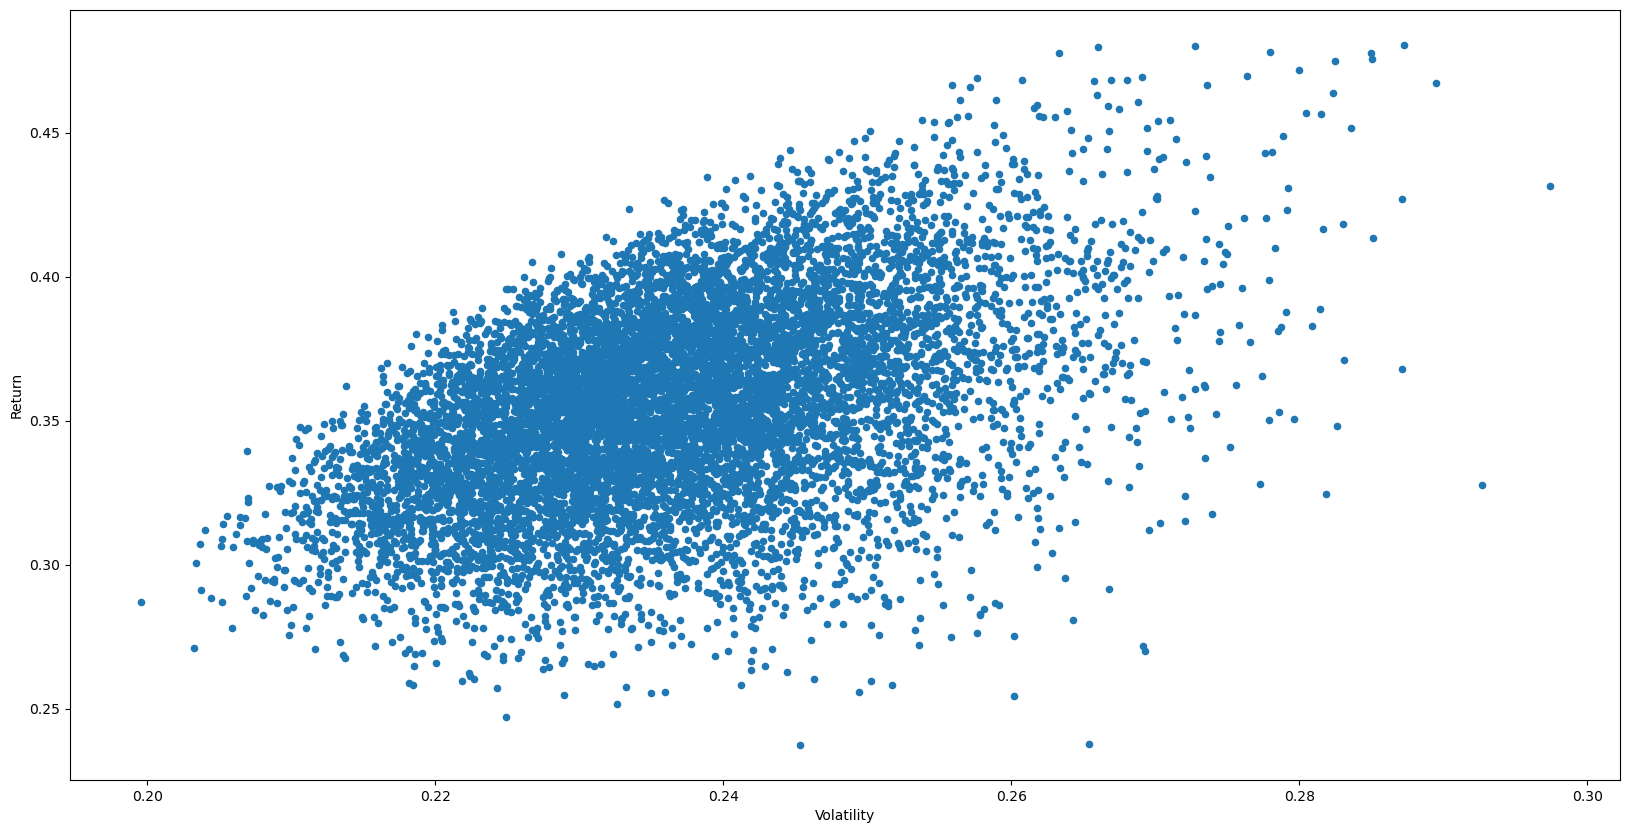

In [48]:
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(20, 10))

In [49]:
# Return the index of the largest Sharpe Ratio
SR_idx = np.argmax(p_SR)
print(p_SR[SR_idx])

# Find the ideal portfolio weighting at that index
i = 0
port_weights = []
while i < num_stocks:
    print("Stock : %s : %2.2f" % (stocks[i], (p_wt[SR_idx][i] * 100)))
    k = round((p_wt[SR_idx][i] * 100))
    port_weights.append(k)
    i += 1
    
# Find volatility of that portfolio
print("\nVolatility :", p_vol[SR_idx])
      
# Find return of that portfolio
print("Return :", p_ret[SR_idx])

1.7748324773617035
Stock : ESABINDIA.NS : 13.12
Stock : EKC.NS : 0.55
Stock : HGS.NS : 1.79
Stock : POLYMED.NS : 1.88
Stock : DIVISLAB.NS : 19.13
Stock : TATAELXSI.NS : 11.79
Stock : ADANITRANS.NS : 22.48
Stock : TATAPOWER.NS : 4.44
Stock : POWERGRID.NS : 2.31
Stock : RELIANCE.NS : 5.41
Stock : ADANIENT.NS : 17.10

Volatility : 0.25590046900507457
Return : 0.46668046336229835


In [50]:
# p_wt[SR_idx]*100
portfolio_wt = list(p_wt[SR_idx]*100)
portfolio_weight = []
for i in portfolio_wt:
    portfolio_weight.append(round(i))
portfolio_weight

[13, 1, 2, 2, 19, 12, 22, 4, 2, 5, 17]

In [51]:
def get_port_shares(one_price, force_one, wts, prices):
    # Gets number of stocks to analyze
    num_stocks = len(wts)
    
    # Holds the number of shares for each
    shares = []
    
    # Holds Cost of shares for each
    cost_shares = []
    
    i = 0
    while i < num_stocks:
        # Get max amount to spend on stock 
        max_price = one_price * wts[i]
        
        # Gets number of shares to buy and adds them to list
        num_shares = int(max_price / prices[i])
        
        # If the user wants to force buying one share do it
        if(force_one & (num_shares == 0)):
            num_shares = 1
        
        shares.append(num_shares)
        
        # Gets cost of those shares and appends to list
        cost = num_shares * prices[i]
        cost_shares.append(cost)
        i += 1
        
    return shares, cost_shares

In [52]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts

In [53]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, 
                                  date, *stocks)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

In [54]:
# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Close',  '2023-03-08', '2023-03-09', *stocks)
# Convert from dataframe to Python list
# print(port_df_start)
port_prices = port_df_start.values.tolist()

# print(port_prices)

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

tot_shares, share_cost = get_port_shares(1776, True, portfolio_weight, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
get_port_val_by_date(E_DATE, tot_shares, stocks)

Shares : [6, 21, 2, 3, 11, 3, 47, 33, 15, 3, 14]
Share Cost : [22796.69970703125, 1745.099967956543, 2413.39990234375, 2926.3500366210938, 31179.5, 19020.6005859375, 38558.80114746094, 6971.25, 3420.750045776367, 7252.05029296875, 28555.100341796875]
Total Investment : 164839.60202789307
Stock Weights : [0.13829625543001337, 0.010586654823767706, 0.014640898622986061, 0.017752712337451022, 0.18915054159572656, 0.11538853741420074, 0.2339170968208008, 0.04229111156686954, 0.020751991655485375, 0.043994587488397394, 0.1732296122443014]


[]